In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import SMOTE

In [2]:
data_train = pd.read_csv("cleaned_2014", low_memory = False);
data_test = pd.read_csv("cleaned_2015", low_memory = False);

In [16]:
data_test = data_test.dropna()

In [17]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt']
x_train_initial, y_train_initial = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [5]:
sm = SMOTE(random_state=1, ratio = 1.0)
x_train, y_train = sm.fit_sample(x_train_initial, y_train_initial)

In [6]:
x_train.shape

(353866, 44)

In [7]:
#create a function to take advantage of sklearn make_pipeline
#pipeline adds second order terms and interaction terms to X_train and then fits model
def rf_model(x, y, d):
    model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(max_depth = d, n_estimators = 100))
    model.fit(x, y)
    return model

rf_complex = rf_model(x_train, y_train, 10)

In [48]:
def create_df(data_1, data_2):
    df = pd.DataFrame(data_1)
    
    df['int_rate'] = data_2['int_rate']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term'] = data_2['term']
    df['ROI'] = ((1 + df['int_rate'])*(1-df['proba']))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term']))-1)
    df['annualized_amnt'] = df['amnt']*(1/df['term'])
    
    return df

In [49]:
train_data = {'proba' : rf_complex.predict_proba(x_train)[:, 1], 'true_val' : y_train}
test_data = {'proba' : rf_complex.predict_proba(x_test)[:, 1], 'true_val' : y_test}

df_train = create_df(train_data, data_train)
df_test =  create_df(test_data, data_test)

In [59]:
baseline_train = np.mean(df_train.ROI)
baseline_test = np.mean(df_test.ROI)
print(baseline_train, baseline_test)
alpha_low = 0.5
alpha_high = -np.inf

-0.3693412707985414 -0.27983136329224284


In [60]:
loans_to_buy_train = df_train[(df_train.ROI > alpha_low*baseline_train) & (df_train.ROI < alpha_high*baseline_train)]
loans_to_buy_test = df_test[(df_test.ROI > alpha_low*baseline_test) & (df_test.ROI < alpha_high*baseline_test)]

In [61]:
def return_performance(df_sub, df_main):
    perf_subset = np.sum(df_sub.Real_ROI)/np.sum(df_sub.annualized_amnt)
    perf_mainset = np.sum(df_main.Real_ROI)/np.sum(df_main.annualized_amnt)
    return (perf_subset, perf_mainset, perf_subset - perf_mainset)

In [62]:
training_set_performance = return_performance(loans_to_buy_train, df_train)
testing_set_performance = return_performance(loans_to_buy_test, df_test)

In [63]:
print(training_set_performance)
print(testing_set_performance)

(0.07854979941777909, 0.04896587539218422, 0.02958392402559487)
(0.05651820868709268, -0.012916755208969084, 0.06943496389606177)


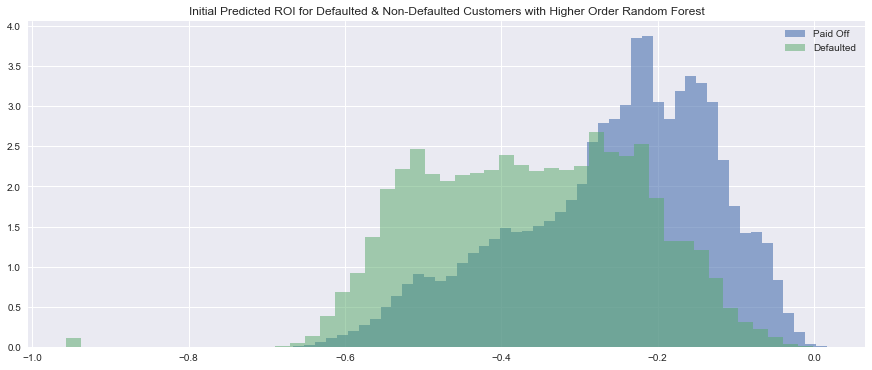

In [58]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(df_test.loc[df_test.true_val == 0,'ROI'], density = True, bins = 50, label='Paid Off', alpha=0.6);
ax.hist(df_test.loc[df_test.true_val == 1,'ROI'], density = True, bins = 50, label='Defaulted', alpha=0.5);
ax.set_title('Initial Predicted ROI for Defaulted & Non-Defaulted Customers with Higher Order Random Forest')
ax.legend(loc='best')

plt.show()